# Рабочий Код

In [12]:
import requests
import datetime
import time
import csv
import time

from openpyxl import Workbook
from openpyxl.utils import get_column_letter
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

**OWNERS_LIST** → ОТКУДА запрашиваем  
**ARGUM_LIST** → ЧТО запрашиваем  

In [13]:
TOKEN_ID = '' # ← Поставь тут твой токен
API_V = '5.126'
#OWNERS_LIST = [-1, -38369814, -142046107, -41669198, -94225164]
OWNERS_LIST = [-1]
ARGUM_LIST = ['id', 'from_id', 'owner_id', 'date', 'text', 'views', 'likes', 'reposts', 'comments']

- ```count``` - количесто постов, которые мы получаем за 1 запрос. Принимает значения от 1 до 100.  
  
- ```offset``` - сдвиг точки отсчёта запроса постов. Чтобы после первых 100 постов запросить следующие 100. Принимает любые целочисленные значения от 0 до бесконечности.  
  
- ```filter_owner``` - Может принимать несколько значений. Мы пока выбираем из двух (str) значений, либо ```owner``` либо ```all```. Где ```all``` - все значения постов, и предлагаемые, и рекламные, и опубликованные. А ```owner``` - опубликованные на стене в данный момент.  
  
- ```group_id``` - айди страницы, с которой собираем посты. Если значение положительное, значит это страница "человека", если отрицательное, значит это паблик\группа.  


Функция которая принимает на вход параметры **owner_id, count, filter_owner, offset**  
совершает ГЕТ запрос на сервер, и возвращает джсон с данными о запрошенном количестве постов  
(количество постов 'count' от 0 до 100):  

In [14]:
def wall_get(owner_id, count, filter_owner, offset):
    try:
        r = requests.get('https://api.vk.com/method/wall.get', params={'owner_id': owner_id,
                                                                       'count': count,
                                                                       'v': API_V,
                                                                       'offset': offset,
                                                                       'filter': filter_owner,
                                                                       'access_token': TOKEN_ID})
    except Exception as err:
        return err
    
    response = r.json()
    return response

Функция, которая принимает на вход group_id = owner_id по модулю (без "-")  
И возвращает количество подписчиков в этой группе, для расчёта ER Post

In [15]:
def folower_count_get(owner_id):
    try:
        rf = requests.get('https://api.vk.com/method/groups.getMembers', params={'group_id': owner_id,
                                                                                 'v': API_V,
                                                                                 'access_token': TOKEN_ID})
    except Exception as err:
        return err
    
    rf_response = rf.json()
    return rf_response['response']['count']

Функция, которая принимает на вход параметры **owner_id, count, filter_owner, offset**  
с которыми обращается к функции **wall_get**, обрабатывает то, что вернула функция **wall_get**  
и, обработав, возвращает Лист, в котором каждый элемент это Словарь, внутри которого данные по всем постам.  
  
На будущее - если захотим делать проверку, собрали ли мы ВСЕ посты, или где-то был сбой,  
можно создать переменную и присвоить ей значение **post_counts = data['response']['count']**  
И сравнивать длинну списка **all_posts** и число в переменной **post_counts**  

In [16]:
def cycle_wall_get(owner_id, count, filter_owner, offset):
    # Объявляем список, внутри которого будем хранить ВСЕ полученные с паблика посты (1 элемент = 1 пост)
    all_posts = [] 
    try:
        while True:
            data = wall_get(owner_id, count, filter_owner, offset)
            items = data['response']['items'] # Получаем список, где каждый элемент - словарь с инфой про посты
            if not items: # Цикл, "пока запрос не вернёт 0 постов - продолжай запрашивать посты"
                break
            all_posts.extend(items) # Записываем полученный отдельным запросом список в общий список постов
            offset += 100
        return all_posts
    except Exception as err:
        return err

Функция **распарсинга**, которая принимает в качестве параметров ключи **views, likes, reposts, comments**  
по которым получает данные каждого поста. Для того, чтобы получить список всех постов,  
присваиваем переменной **all_posts** объект, которой нам возвращает функция **cycle_wall_get()**  
проходим циклом по каждому посту в списке, и в каждой итерации получает словарь с нужными данными по посту.  
Затем вносит полученные **.values()** в итоговый  

In [17]:
def post_keys_values(post, owner_id, count, filter_owner, offset):
    post_dict = {k: post[k]['count'] if k in post and type(post[k]) == dict 
                  else post.setdefault(k, 0) for k in ARGUM_LIST}
    return post_dict

In [18]:
def post_db(owner_id, count, filter_owner, offset):
    # Инициируем словарь, в который будем складывать распарсенные данные
    all_data = {k: [] for k in ARGUM_LIST}
    all_posts = cycle_wall_get(owner_id, count, filter_owner, offset) # Получили список, где каждый элемент - пост
    
    for post in all_posts:       
        d = post_keys_values(post, owner_id, count, filter_owner, offset) # Получили словарь, с данными по посту
        for k in ARGUM_LIST:
            all_data[k].append(d[k])
            
    return all_data

In [19]:
def save_db_csv(owner_id, count, filter_owner, offset):
    all_data = post_db(owner_id, count, filter_owner, offset)
    df = pd.DataFrame.from_dict(all_data, dtype='int64')
    #df['date'] = pd.to_datetime(df['date'], unit='s') # Конвертируем время в датафрейме сразу, до записи в файл
    df.to_csv('vk_wall_get.csv', header=False, mode='a', float_format = '%.0f')
    return df

Задаём параметры owner_id для запроса, меняем как хотим:  
  
Маленький объём данных owner_id vk api public -1  
Средний объем данных owner_id смм блог Сергея -38369814  
Пармарщина -41669198  
Kairos -94225164  
Большой объём данных owner_id VLP -142046107  
Огромный объем данных owner_id МДК -57846937  

In [11]:
# Вызываем функцию, передаём в неё необходимые параметры, получаем результат
save_db_csv(-1, 100, 'owner', 0)

,id,from_id,owner_id,date,text,views,likes,reposts,comments
0,397203,-1,-1,1607330700,10 декабря в 19:00 собираемся на седьмом митап...,10288,47,0,40
1,397107,-1,-1,1607010912,Прокачали messages.pin: отныне бот с правами а...,12201,131,3,69
2,397065,-1,-1,1606899366,Теперь можно размещать свой проект сразу на дв...,6637,35,0,40
3,396954,-1,-1,1605274457,"Делимся некоторыми изменениями, связанными с C...",13572,72,2,29
4,396931,-1,-1,1605185315,Выведите заработок на новый уровень — на 130% ...,340186,376,2,13
...,...,...,...,...,...,...,...,...,...
176,240436,-1,-1,1296906872,Теперь openApi приложения тоже могут использов...,0,145,5,31
177,238413,-1,-1,1296834053,Подключение виджетов в IFrame-приложениях http...,0,103,7,5
178,236533,-1,-1,1296757026,Обновлён метод wall.post для публикации записе...,0,116,7,9
179,55229,-1,-1,1289247197,Результаты второго этапа конкурса на разработк...,0,686,9,27


In [ ]:
# Малый паблик (181 пост на стене) -1
owner_id = -1
save_db_csv(owner_id, count, filter_owner, offset)
# executed in 865ms \ 934ms

In [ ]:
# Средний паблик (до 3 тыс постов) -38369814
owner_id = -38369814
save_db_csv(owner_id, count, filter_owner, offset)
# executed in 19.1s

In [ ]:
# Большой паблик (до 10 тыс постов) -142046107
owner_id = -142046107
save_db_csv(owner_id, count, filter_owner, offsets)
# executed in 58.2s

In [ ]:
# Огромный паблик (дофига постов - апд было примерно 70 тыс постов) -57846937
owner_id = -57846937
save_db_csv(owner_id, count, filter_owner, offset)
# executed in 9m 24s

In [ ]:
Отлично! Замерили выполнение всего скрипта на пабликах разного объёма.
И получили вполне адекватные цифры.

Идём дальше, строим графики, анализируем.


# Эксперименты c Pandas

Тут эксперименты с функциями, не аналитика как таковая.  
Пробовать будем на паблике SMM блог

In [66]:
owner_id = -38369814
count = 100
filter_owner = 'owner'
offset = 0
views = 'views'
likes = 'likes'
reposts = 'reposts'
comments = 'comments'

In [67]:
# Создаём стартовый ДатаФрейм
df = save_db_csv(owner_id, count, filter_owner, offset, views, likes, reposts, comments)

In [68]:
# Создаём экспериментальный ДатаФрейм на основе стартового, чтобы не навредить стартовому
df2 = df.copy()
df2

,id,date,text,views,likes,reposts,comments
0,23427,2020-10-24 23:00:18,Мой телеграм-канал: https://t.me/smmblog\n\nВ ...,1123,2,0,1
1,23450,2020-11-22 19:14:22,телеграм-канал такой же урл как и в ВК [club38...,467,4,0,1
2,23447,2020-11-17 12:29:17,"Огромные силы были потрачены на этот материал,...",391,1,0,7
3,23446,2020-11-14 13:09:23,Приходите! Подключайтесь! Получайте бонусы и п...,405,0,0,1
4,23445,2020-11-14 13:06:25,вот чем я примерно занимаюсь в [club162517727|...,609,1,2,0
...,...,...,...,...,...,...,...
2766,7,2012-05-01 16:48:53,Взял интервью у владельца паблика [club2431374...,None,3,1,1
2767,6,2012-05-01 11:31:20,,None,5,2,0
2768,5,2012-04-29 22:35:35,Ресурсы по SMM и Digital\n\nЗдесь собраны ресу...,None,4,2,0
2769,3,2012-04-29 18:12:10,Во что эволюционируют рекламные агентства стар...,None,2,0,0


In [ ]:
Создадим новый столбец со ссылкой на пост

In [69]:
df2['link'] = 'https://vk.com/wall' + str(owner_id) + '_' + df2['id'].map(str)
df2['link']

0       https://vk.com/wall-38369814_23427
1       https://vk.com/wall-38369814_23450
2       https://vk.com/wall-38369814_23447
3       https://vk.com/wall-38369814_23446
4       https://vk.com/wall-38369814_23445
                       ...                
2766        https://vk.com/wall-38369814_7
2767        https://vk.com/wall-38369814_6
2768        https://vk.com/wall-38369814_5
2769        https://vk.com/wall-38369814_3
2770        https://vk.com/wall-38369814_2
Name: link, Length: 2771, dtype: object

In [ ]:
И удалим ненужный столбец с id, чтоб не мешался, он своё дело сделал

In [70]:
df2.drop(['id'], axis=1)

,date,text,views,likes,reposts,comments,link
0,2020-10-24 23:00:18,Мой телеграм-канал: https://t.me/smmblog\n\nВ ...,1123,2,0,1,https://vk.com/wall-38369814_23427
1,2020-11-22 19:14:22,телеграм-канал такой же урл как и в ВК [club38...,467,4,0,1,https://vk.com/wall-38369814_23450
2,2020-11-17 12:29:17,"Огромные силы были потрачены на этот материал,...",391,1,0,7,https://vk.com/wall-38369814_23447
3,2020-11-14 13:09:23,Приходите! Подключайтесь! Получайте бонусы и п...,405,0,0,1,https://vk.com/wall-38369814_23446
4,2020-11-14 13:06:25,вот чем я примерно занимаюсь в [club162517727|...,609,1,2,0,https://vk.com/wall-38369814_23445
...,...,...,...,...,...,...,...
2766,2012-05-01 16:48:53,Взял интервью у владельца паблика [club2431374...,None,3,1,1,https://vk.com/wall-38369814_7
2767,2012-05-01 11:31:20,,None,5,2,0,https://vk.com/wall-38369814_6
2768,2012-04-29 22:35:35,Ресурсы по SMM и Digital\n\nЗдесь собраны ресу...,None,4,2,0,https://vk.com/wall-38369814_5
2769,2012-04-29 18:12:10,Во что эволюционируют рекламные агентства стар...,None,2,0,0,https://vk.com/wall-38369814_3


In [74]:
df2.plot('date', 'likes')

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

In [ ]:
Обзор не очень удобный, из-за пары всплесков значений.
Отрежем их:

In [81]:
df2[df2['likes'] < 400].plot('date','likes')

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

In [ ]:
Посмотрим, сколько постов собрали больше 120 лайков

In [48]:
df2[df2['likes'] > 120]

,id,date,views,likes,reposts,comments,link
106,22796,2018-09-21 08:03:11,7645,128,43,4,https://vk.com/wall-38369814_22796
300,20766,2016-10-12 10:12:37,None,144,23,38,https://vk.com/wall-38369814_20766
318,20605,2016-09-10 18:22:49,None,169,53,25,https://vk.com/wall-38369814_20605
327,20528,2016-09-01 09:26:19,None,123,17,16,https://vk.com/wall-38369814_20528
411,19543,2016-04-30 07:24:44,None,125,46,14,https://vk.com/wall-38369814_19543
444,19116,2016-03-22 07:05:05,None,136,41,9,https://vk.com/wall-38369814_19116
456,19015,2016-03-04 11:23:44,None,134,38,1,https://vk.com/wall-38369814_19015
503,18307,2015-10-27 16:49:54,None,190,59,10,https://vk.com/wall-38369814_18307
778,15729,2015-04-01 10:27:48,None,224,3,39,https://vk.com/wall-38369814_15729
842,15138,2015-02-16 07:45:41,None,121,38,0,https://vk.com/wall-38369814_15138


In [ ]:
Посчитаем их количество:

In [29]:
df2[lambda x: x['likes'] > 120].count()

id          23
date        23
views        1
likes       23
reposts     23
comments    23
link        23
dtype: int64

In [ ]:
Посмотрим максимальные значения по ВСЕМ столбцам.
Смотреть "мах" по ссылке и времени, правда, бесполезно, 
зато не тратим время прописывая инструкцию отдельно на каждый столбец

In [31]:
df2.max()

id                                      23450
date                      2020-11-22 19:14:22
views                                   16165
likes                                    1537
reposts                                   291
comments                                  154
link        https://vk.com/wall-38369814_9995
dtype: object

In [ ]:
Посмотрим сводные данные по конкретному столбцу:

In [32]:
df2['views'].describe()

count      262
unique     259
top       3337
freq         2
Name: views, dtype: int64

In [ ]:
Как видим, постов у которых "views" != NaN всего 262 из общего числа

In [33]:
df2['likes'].describe()
'''
Всего 2771 значение
Среднее значение
Стандартное отклонение
Минимальное значение
Дальше разбивка по перцентилям
Максимальное значение
'''

count    2771.000000
mean       15.748466
std        39.783419
min         0.000000
25%         3.000000
50%         8.000000
75%        18.000000
max      1537.000000
Name: likes, dtype: float64

In [ ]:
Посмотрим срез по дате:

In [100]:
srez = df2[df2['date'].between('2017-11-01','2017-11-30', inclusive=True)]
srez

,id,date,views,likes,reposts,comments,link
190,22169,2017-11-24 20:00:57,2486,11,3,5,https://vk.com/wall-38369814_22169
191,22168,2017-11-24 08:24:46,2392,15,4,0,https://vk.com/wall-38369814_22168
192,22156,2017-11-17 07:54:27,2468,2,1,0,https://vk.com/wall-38369814_22156
193,22149,2017-11-14 07:09:50,2540,14,3,0,https://vk.com/wall-38369814_22149
194,22143,2017-11-12 13:45:14,2831,15,2,4,https://vk.com/wall-38369814_22143
195,22130,2017-11-07 23:41:57,3078,9,0,3,https://vk.com/wall-38369814_22130
196,22128,2017-11-07 16:56:02,2638,14,7,0,https://vk.com/wall-38369814_22128
197,22125,2017-11-07 12:55:00,2741,37,17,1,https://vk.com/wall-38369814_22125
198,22111,2017-11-02 12:39:30,3458,40,6,3,https://vk.com/wall-38369814_22111


<IPython.core.display.Javascript object>


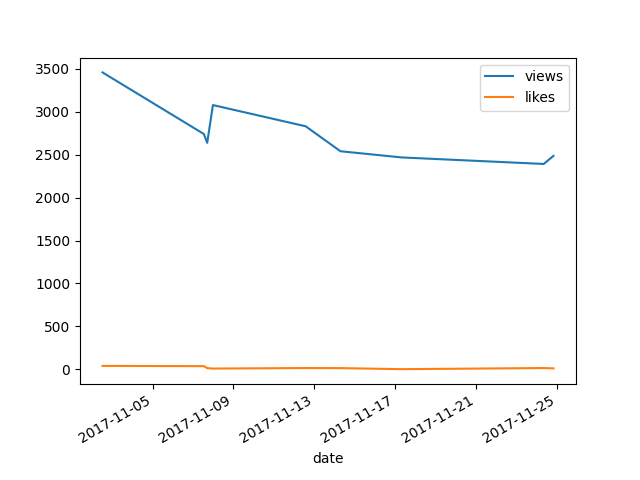

<AxesSubplot:xlabel='date'>

In [103]:
srez.plot('date', ['views', 'likes'])

In [19]:
df2.describe()

,id,likes,reposts,comments
count,2771.000000,2771.000000,2771.000000,2771.000000
mean,10376.593288,15.748466,3.582100,5.442079
std,7292.237209,39.783419,10.059571,8.924906
min,2.000000,0.000000,0.000000,0.000000
25%,4035.500000,3.000000,0.000000,0.000000
50%,10117.000000,8.000000,1.000000,2.000000
75%,16686.000000,18.000000,4.000000,7.000000
max,23450.000000,1537.000000,291.000000,154.000000


In [ ]:
Теперь посчитаем ER_view по каждому посту:
ER_view = (сумма лайков + сумма комментов + сумма репостов) / просмотр поста
ER_view по паблику = сумма ER_view по всем постам / количество постов

In [ ]:
df2['ER_view'] = 

# Анализ N пабликов в одной таблице

Соберём количество подписчиков в пабликах, которые анализируем, для рассчёта ER Post и других метрик:

In [21]:
followers = {owner_id: folower_count_get(abs(owner_id)) for owner_id in OWNERS_LIST}
followers

{-1: 382180,
 -38369814: 29303,
 -142046107: 143167,
 -41669198: 2132,
 -94225164: 10587}

Прогоним цикл по N пабликам, указанным в константе PUBLIC_LIST

In [22]:
for owner_id in OWNERS_LIST:
    count = 100
    filter_owner = 'owner'
    offset = 0
    save_db_csv(owner_id, count, filter_owner, offset)
    

In [73]:
#headers = ['Дата публикации', 'Ссылка', 'Просмотров', 'Лайков', 'Репостов', 'Комментариев']
raw_df = pd.read_csv('vk_wall_get_demo.csv', header=None)
raw_df.columns=['N', 'id', 'from_id', 'owner_id', 'date', 'text', 'views', 'likes', 'reposts', 'comments']
raw_df['link'] = 'https://vk.com/wall' + raw_df['owner_id'].map(str) + '_' + raw_df['id'].map(str)
raw_df

,N,id,from_id,owner_id,date,text,views,likes,reposts,comments,link
0,0,397203,-1,-1,1607330700,10 декабря в 19:00 собираемся на седьмом митап...,10011,46,0,36,https://vk.com/wall-1_397203
1,1,397107,-1,-1,1607010912,Прокачали messages.pin: отныне бот с правами а...,12043,130,3,68,https://vk.com/wall-1_397107
2,2,397065,-1,-1,1606899366,Теперь можно размещать свой проект сразу на дв...,6515,35,0,40,https://vk.com/wall-1_397065
3,3,396954,-1,-1,1605274457,"Делимся некоторыми изменениями, связанными с C...",13481,72,2,29,https://vk.com/wall-1_396954
4,4,396931,-1,-1,1605185315,Выведите заработок на новый уровень — на 130% ...,340115,376,2,13,https://vk.com/wall-1_396931
...,...,...,...,...,...,...,...,...,...,...,...
10667,259,5,-94225164,-94225164,1447152969,Мы предлагаем нашим клиентам протестировать на...,0,7,0,0,https://vk.com/wall-94225164_5
10668,260,4,-94225164,-94225164,1446568624,Кейс рекламной кампании одного из наших клиент...,0,8,2,0,https://vk.com/wall-94225164_4
10669,261,3,-94225164,-94225164,1446567579,Компания Zemadia проводит закрытый бета-тест а...,0,8,0,0,https://vk.com/wall-94225164_3
10670,262,2,-94225164,-94225164,1442566906,NaN,0,13,2,0,https://vk.com/wall-94225164_2


Проверим, сколько уникальных айди пабликов есть в столбце.
Количество должно совпасть.

In [69]:
raw_df['owner_id'].unique()

array([        -1,  -38369814, -142046107,  -41669198,  -94225164])

Совпало